### Load and visualize data.

In [1]:
import tensorflow as tf

In [2]:
from tensorflow.keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [3]:
print('total training images: ', len(X_train))
print('total testing images: ', len(X_test))

total training images:  50000
total testing images:  10000


In [4]:
cimg_shape = X_train[0].shape
print('image shape:', cimg_shape)

image shape: (32, 32, 3)


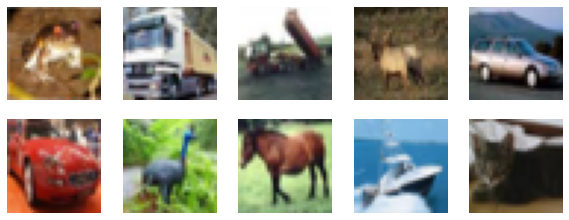

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
nrows = 5
ncols = 5

fig = plt.gcf()
fig.set_size_inches(nrows * 2, ncols * 2)

img_indices = random.choices(range(len(y_train)), k=(nrows + ncols))
for i in range(len(img_indices)):
    sp = plt.subplot(nrows, ncols, i+1)
    sp.axis('Off')

    plt.imshow(X_train[i])

### Transfer learning



Load a pre-trained model ResNet50.

In [6]:
from tensorflow.keras.applications.resnet import ResNet50

pre_trained = ResNet50(input_shape=(224, 224, 3), # different dim from CIFAR images
                       weights='imagenet',
                       include_top=False)

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, UpSampling2D, Lambda, GlobalAveragePooling2D, Flatten

class CIFAR_CLS(Model):
    
    def __init__(self, pre_trained, n_classes):
        super(CIFAR_CLS, self).__init__()

        self.pre_trained = pre_trained
        self.up_sample = UpSampling2D(7)
        self.normalize = Lambda(lambda image: tf.cast(image, tf.float32) / 255.)
        self.match_resnet_input = Lambda(tf.keras.applications.resnet50.preprocess_input)
        self.global_avg = GlobalAveragePooling2D()
        self.flatten = Flatten()
        self.dense1 = Dense(1024, activation='relu')
        self.dense2 = Dense(512, activation='relu')
        self.output_layer = Dense(n_classes, activation='softmax', name='output_layer')

    def call(self, inputs):
        # preprocess inputs
        x = self.up_sample(inputs)
        x = self.normalize(x)
        x = self.match_resnet_input(x)

        # extract features
        x = self.pre_trained(x)
        x = self.global_avg(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)

        # prediction
        x = self.output_layer(x)

        return x

In [9]:
model = CIFAR_CLS(pre_trained, len(classes))
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='SGD',
              metrics=['acc'])

In [10]:
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test), batch_size=32) # takes too long to train on my machine.

Epoch 1/5
   4/1563 [..............................] - ETA: 9:17:14 - loss: 2.3760 - acc: 0.1686

KeyboardInterrupt: ignored

In [ ]:
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']

epochs = range(len(history.epoch))

plt.plot(epochs, accuracy, label='acc')
plt.plot(epochs, val_accuracy, label='val')
plt.legend()
plt.show()